In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math as mt
import pandas as pd
import seaborn as sb
from pandas import HDFStore
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.lpf_ww import LPFunction as LPFW
from src.lpf_wr import LPFunction as LPFR

from src.core import *

In [3]:
fwn = pd.read_hdf('results/pe.h5','bb/wn_nomask')
fwm = pd.read_hdf('results/pe.h5','bb/wn_masked')
frn = pd.read_hdf('results/pe.h5','bb/rn_nomask')
frm = pd.read_hdf('results/pe.h5','bb/rn_masked')

In [4]:
pe = pd.Panel(dict(wn = pd.read_hdf('results/pe.h5','bb/wn_nomask'),
                   wm = pd.read_hdf('results/pe.h5','bb/wn_masked'),
                   rn = pd.read_hdf('results/pe.h5','bb/rn_nomask'),
                   rm = pd.read_hdf('results/pe.h5','bb/rn_masked')))

for name,df in pe.iteritems():
    df['e_ppm'] = 1e6*df.e

## Plots 

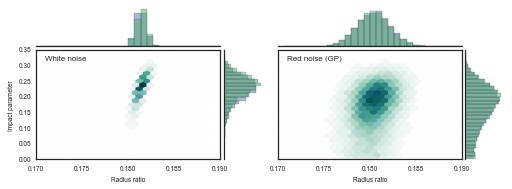

In [7]:
def hexbin2(fig, ax, a1, a2, b1, b2, alim, blim, gs):
    h1 = ax.hexbin(a1, b1, extent=(alim[0],alim[1],blim[0],blim[1]), 
                   gridsize=gs, cmap=plt.cm.Blues)
    h2 = ax.hexbin(a2, b2, extent=(alim[0],alim[1],blim[0],blim[1]), 
                   gridsize=gs, cmap=plt.cm.Greens)
    fig.canvas.draw()
    fc = h1.get_facecolors() + h2.get_facecolors()
    fc *= 0.5
    fc[fc[:,:3].sum(1)>2.9,:] = array([1,1,1,1])
    h2.set_facecolors(fc)
    fig.canvas.draw()
    ax.set_xlim(*klim)
    ax.set_ylim(*blim)
   
cn, cm = cp[2], cp[3]
klim = (0.17,0.19)
blim = (0.,0.35)
msize, mpad = 0.55, 0.05

with sb.plotting_context('paper', rc=rc_paper):
    fig, axs = subplots(1,2, figsize=(AAPGW,0.75*AAOCW), sharey=True, sharex=True)
    divs = [make_axes_locatable(ax) for ax in axs]
    axhys = [div.append_axes('top',   size=msize, pad=mpad, sharex=axs[i]) for i,div in enumerate(divs)]
    axhxs = [div.append_axes('right', size=msize, pad=mpad, sharey=axs[i]) for i,div in enumerate(divs)]

    hexbin2(fig, axs[0], fwn.k, fwm.k, fwn.b, fwm.b, klim, blim, 25)
    hexbin2(fig, axs[1], frn.k, frm.k, frn.b, frm.b, klim, blim, 25)

    axhys[0].hist(fwn.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cn)
    axhys[0].hist(fwm.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cm)
    axhxs[0].hist(fwn.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cn)
    axhxs[0].hist(fwm.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cm)
    axhys[1].hist(frn.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cn)
    axhys[1].hist(frm.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cm)
    axhxs[1].hist(frn.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cn)
    axhxs[1].hist(frm.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cm)

    setp(axhys[0].get_yticklabels()+axhys[1].get_yticklabels(), visible=False)
    setp(axhys[0].get_xticklabels()+axhys[1].get_xticklabels(), visible=False)
    setp(axhxs[0].get_yticklabels()+axhxs[1].get_yticklabels(), visible=False)
    setp(axhxs[0].get_xticklabels()+axhxs[1].get_xticklabels(), visible=False)

    [sb.despine(ax=a, left=True) for a in axhys]
    [sb.despine(ax=a, bottom=True) for a in axhxs]

    axs[0].text(0.05, 0.9, 'White noise', size=8, transform=axs[0].transAxes)
    axs[1].text(0.05, 0.9, 'Red noise (GP)', size=8, transform=axs[1].transAxes)

    setp(axs[0], xlim=(0.17,0.19), ylim=blim)
    setp(axhxs, ylim=blim)
    setp(axs[0], xlabel='Radius ratio', ylabel='Impact parameter')
    setp(axs[1], xlabel='Radius ratio')
    fig.tight_layout()
    fig.savefig('plots/pub_white_k_and_b.pdf')

In [14]:
def get_range(p):
    pn = percentile(pe.wn[p].dropna(), [0.25,99.75])
    pm = percentile(pe.wm[p].dropna(), [0.25,99.75])
    return [min(pn[0],pm[0]),max(pn[1],pm[1])]

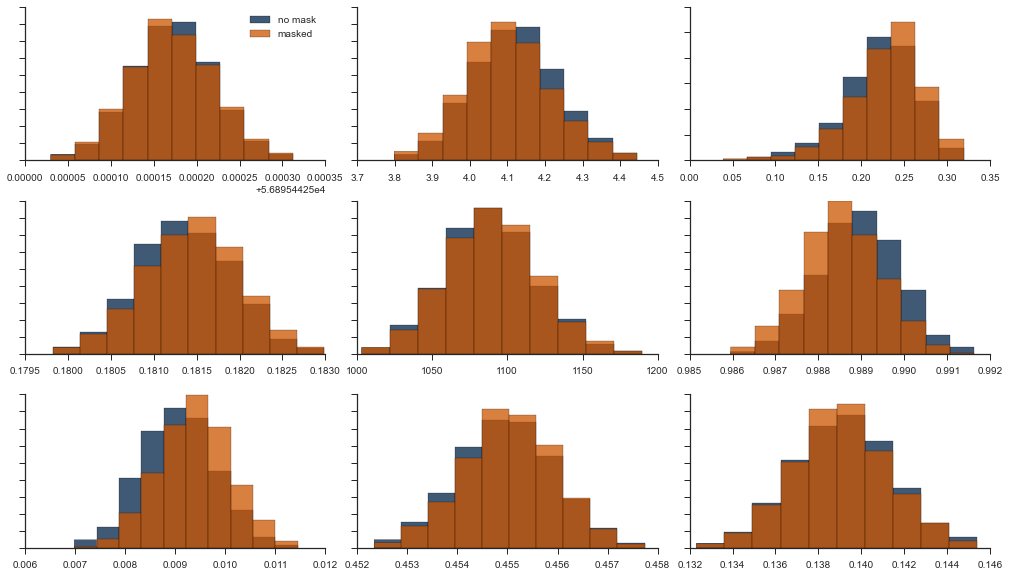

In [15]:
pars = 'tc rho b k e_ppm c x u v'.split()
cp = sb.color_palette()

with sb.axes_style('ticks'):
    fig,axs = subplots(3,3,figsize=(14,8))
    for i,p in enumerate(pars):
        rng = get_range(p)
        pe.wn[p].dropna().hist(ax=axs.flat[i], fc=cp[0], range=rng, label='no mask', grid=False, alpha=0.75)
        pe.wm[p].dropna().hist(ax=axs.flat[i], fc=cp[1], range=rng, label='masked', grid=False, alpha=0.75)
        setp(axs.flat[i].get_yticklabels(), visible=False)
    axs.flat[0].legend()
    sb.despine(fig)
    fig.tight_layout()

In [16]:
def estimate(d):
    p = array(percentile(d, [50,16,84]))
    return p[0], abs(p[1:]-p[0]).mean()
estimate(pe.wn.tc)

(nan, nan)

## Light curve plots

In [18]:
df_aux = pd.read_hdf('results/light_curves.h5', 'aux')
df_lc  = pd.read_hdf('results/light_curves.h5', 'final/bb_masked')
msk = array(df_aux.bad_mask, dtype=np.bool)

lpfw = LPFW(array(df_aux.mjd+0.5)[msk], df_lc.white[msk], df_aux.airmass[msk], 4)
lpfr = LPFR(array(df_aux.mjd+0.5)[msk], df_lc.white[msk], df_aux.airmass[msk], 4)

In [19]:
chains = array(pe.wm.get('tc p rho b k2 e c x u v'.split()).dropna())
flux_md = array([lpfw.compute_lc_model(pv) for pv in chains])
flux_mp = percentile(flux_md, [50,2.5,97.5], 0)
flux_bd = array([lpfw.compute_baseline(pv) for pv in chains])
flux_bp = percentile(flux_bd, [50,2.5,97.5], 0)

In [20]:
time       = lpfw.time
flux_o     = lpfw.flux_o.ravel()
flux_m     = flux_mp[0,:]
residuals  = flux_o - flux_m

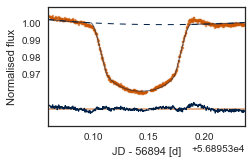

In [39]:
fig,ax = subplots(1,1, figsize=(AAOCW,0.65*AAOCW))
ax.plot(time, flux_o, '.', c=c_bo, alpha=0.25, ms=5.5)
ax.plot(time, flux_o, '.', c=c_bo, alpha=0.5, ms=4.5, markeredgecolor=c_bo)
ax.fill_between(time, *flux_mp[1:,:], alpha=0.2)
ax.plot(time, flux_bp[0,:], '--', c=c_ob, lw=1)
ax.plot(time, flux_mp[0,:], '-', c=c_ob, alpha=0.5, lw=1)
ax.axhline(0.95, ls='-', alpha=0.5, c=c_bo)
ax.plot(time, residuals+0.95, '-', c=c_ob, drawstyle='steps-mid', lw=1)
setp(ax, xlim=time[[0,626]], ylabel='Normalised flux', xlabel='JD - {:d} [d]'.format(int(df_aux.mjd[0])), 
     yticks=[0.97,0.98,0.99,1.0])
fig.tight_layout()
fig.savefig('plots/white_lc_and_model.pdf')

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>